In [7]:
from utils.SaxImage import SAXImage
from utils.LaxImage import LAXImage
import SimpleITK as sitk
import os
import numpy as np
import cv2
from skimage import transform
from torchvision import transforms
import torch

subject = "/home/ngaggion/Documentos/Leeds/Dataset/Subjects/1030914/image/time001"

SAX_PATH = os.path.join(subject, "SAX")
LAX_PATH = os.path.join(subject, "LAX")
LAX_2CH_PATH = os.path.join(LAX_PATH, "2CH", '0001')
LAX_3CH_PATH = os.path.join(LAX_PATH, "3CH", '0001')
LAX_4CH_PATH = os.path.join(LAX_PATH, "4CH", '0001')

SaxImage = SAXImage(SAX_PATH)
SaxImage_array = SaxImage.pixel_array()
SaxImage_array = (SaxImage_array - np.min(SaxImage_array)) / (np.max(SaxImage_array) - np.min(SaxImage_array))

try:
    Lax2CH = LAXImage(LAX_2CH_PATH)
    Lax2CH_array = Lax2CH.pixel_array()
    Lax2CH_array = (Lax2CH_array - np.min(Lax2CH_array)) / (np.max(Lax2CH_array) - np.min(Lax2CH_array))
except:
    Lax2CH = None
    Lax2CH_array = np.zeros((224, 224, 1))

try:
    Lax3CH = LAXImage(LAX_3CH_PATH)
    Lax3CH_array = Lax3CH.pixel_array()
    Lax3CH_array = (Lax3CH_array - np.min(Lax3CH_array)) / (np.max(Lax3CH_array) - np.min(Lax3CH_array))
except:
    Lax3CH = None
    Lax3CH_array = np.zeros((224, 224, 1))
    
try:
    Lax4CH = LAXImage(LAX_4CH_PATH)
    Lax4CH_array = Lax4CH.pixel_array()
    Lax4CH_array = (Lax4CH_array - np.min(Lax4CH_array)) / (np.max(Lax4CH_array) - np.min(Lax4CH_array))
except:
    Lax4CH = None
    Lax4CH_array = np.zeros((224, 224, 1))

mesh = np.load(os.path.join(subject.replace("image", "mesh"), "surface.npy"))

sample = {'SAX': SaxImage, 'LAX2CH': Lax2CH, 'LAX3CH': Lax3CH, 'LAX4CH': Lax4CH, 'Mesh': mesh,
          'Sax_Array': SaxImage_array, 'Lax2CH_Array': Lax2CH_array, 'Lax3CH_Array': Lax3CH_array, 'Lax4CH_Array': Lax4CH_array}

In [8]:
class AlignMeshWithSaxImage(object):
    """
    Aligns the mesh with the SAX image.
    """

    def __call__(self, sample):
        sax_image = sample['SAX']
        mesh = sample['Mesh']
        
        # Get the origin of the image
        origin = np.array(sax_image.origin)
        
        # Calculate the pixel size in each dimension
        pixel_size = np.array(sax_image.spacing)

        # Calculate the direction matrix from the direction cosines
        direction_matrix = np.array(sax_image.direction).reshape(3, 3)

        # Calculate the inverse of the direction matrix
        inverse_direction_matrix = np.linalg.inv(direction_matrix)

        # Convert the physical points to voxel indices by subtracting the origin and multiplying with the inverse direction matrix
        voxel_indices = np.dot((mesh - origin), inverse_direction_matrix.T)

        # Convert the voxel indices to image space by dividing by the pixel size
        image_space_points = voxel_indices / pixel_size
        
        sample['Mesh'] = image_space_points
        
        return sample
    

def _get_both_paddings(desired, actual):
        pad = (desired - actual)
        
        v1 = int(pad / 2)
        v2 = int(pad / 2) 
        if (v1 + v2) < pad:
            v2 += 1
        
        return (v1, v2)
    
    
class PadArraysToSquareShape(object):
    """
    Zero pads SAX and LAX image arrays to fixed square shape.
    SAX_IMAGE_SHAPE = (210, 210, 16)
    LAX_IMAGE_SHAPE = (224, 224, 1)
    """

    def __call__(self, sample):
        SAX_IMAGE_SHAPE = (210, 210, 16)
        LAX_IMAGE_SHAPE = (224, 224, 1)
        
        sax_array = sample['Sax_Array']
        lax2ch_array = sample['Lax2CH_Array']
        lax3ch_array = sample['Lax3CH_Array']
        lax4ch_array = sample['Lax4CH_Array']
        
        sax_h_paddings = _get_both_paddings(SAX_IMAGE_SHAPE[0], sax_array.shape[0])
        sax_w_paddings = _get_both_paddings(SAX_IMAGE_SHAPE[1], sax_array.shape[1])
        sax_z_paddings = _get_both_paddings(SAX_IMAGE_SHAPE[2], sax_array.shape[2])
        
        sax_array = np.pad(sax_array, (sax_h_paddings, sax_w_paddings, sax_z_paddings), 'constant', constant_values=0)
        
        mesh = sample['Mesh']
        mesh[:, 0] += sax_w_paddings[0]
        mesh[:, 1] += sax_h_paddings[0]
        mesh[:, 2] += sax_z_paddings[0]
        sample['Mesh'] = mesh
        
        lax2ch_h_paddings = _get_both_paddings(LAX_IMAGE_SHAPE[0], lax2ch_array.shape[0])
        lax2ch_w_paddings = _get_both_paddings(LAX_IMAGE_SHAPE[1], lax2ch_array.shape[1])
        
        lax2ch_array = np.pad(lax2ch_array, (lax2ch_h_paddings, lax2ch_w_paddings, (0, 0)), 'constant', constant_values=0)
        
        lax3ch_h_paddings = _get_both_paddings(LAX_IMAGE_SHAPE[0], lax3ch_array.shape[0])
        lax3ch_w_paddings = _get_both_paddings(LAX_IMAGE_SHAPE[1], lax3ch_array.shape[1])
        
        lax3ch_array = np.pad(lax3ch_array, (lax3ch_h_paddings, lax3ch_w_paddings, (0, 0)), 'constant', constant_values=0)
        
        lax4ch_h_paddings = _get_both_paddings(LAX_IMAGE_SHAPE[0], lax4ch_array.shape[0])
        lax4ch_w_paddings = _get_both_paddings(LAX_IMAGE_SHAPE[1], lax4ch_array.shape[1])
        
        lax4ch_array = np.pad(lax4ch_array, (lax4ch_h_paddings, lax4ch_w_paddings, (0, 0)), 'constant', constant_values=0)
        
        sample['Sax_Array'] = sax_array
        sample['Lax2CH_Array'] = lax2ch_array
        sample['Lax3CH_Array'] = lax3ch_array
        sample['Lax4CH_Array'] = lax4ch_array
        
        return sample
    
    
def pad_or_crop_image_and_mesh(sax_array, mesh, new_sax_h, new_sax_w, SAX_IMAGE_SHAPE):
    # Estimates new mesh limits
    min_h = np.min(mesh[:, 1])
    max_h = np.max(mesh[:, 1])
    mesh_height = max_h - min_h

    min_w = np.min(mesh[:, 0])
    max_w = np.max(mesh[:, 0])
    mesh_width = max_w - min_w  

    # Adjust height
    if new_sax_h < SAX_IMAGE_SHAPE[0]:
        padding = _get_both_paddings(SAX_IMAGE_SHAPE[0], new_sax_h)
        pad_h_1 = np.random.randint(0, padding[0] + padding[1])
        pad_h_2 = padding[0] + padding[1] - pad_h_1
        mesh[:, 1] += pad_h_1
        sax_array = np.pad(sax_array, ((pad_h_1, pad_h_2), (0, 0), (0, 0)), 'constant', constant_values=0)
    else:
        crop_amount = new_sax_h - SAX_IMAGE_SHAPE[0]
        crop_left_limit = min(crop_amount, min_w)
        random_crop_left = np.random.randint(0, crop_left_limit)
        crop_right = crop_amount - random_crop_left
        sax_array = sax_array[random_crop_left:-crop_right, :, :]
        mesh[:, 1] -= random_crop_left 

    # Adjust width
    if new_sax_w < SAX_IMAGE_SHAPE[1]:
        padding = _get_both_paddings(SAX_IMAGE_SHAPE[1], new_sax_w)
        pad_w_1 = np.random.randint(0, padding[0] + padding[1])
        pad_w_2 = padding[0] + padding[1] - pad_w_1
        mesh[:, 0] += pad_w_1
        sax_array = np.pad(sax_array, ((0, 0), (pad_w_1, pad_w_2), (0, 0)), 'constant', constant_values=0)
    else:
        crop_amount = new_sax_w - SAX_IMAGE_SHAPE[1]
        crop_left_limit = min(crop_amount, min_h)
        random_crop_left = np.random.randint(0, crop_left_limit)
        crop_right = crop_amount - random_crop_left
        sax_array = sax_array[:, random_crop_left:-crop_right, :]
        mesh[:, 0] -= random_crop_left
        
    # Always pad the z axis to the desired shape
    padding = _get_both_paddings(SAX_IMAGE_SHAPE[2], sax_array.shape[2])
    sax_array = np.pad(sax_array, ((0, 0), (0, 0), padding), 'constant', constant_values=0)
    mesh[:, 2] += padding[0]
        
    return sax_array, mesh


class RandomScalingSAX(object):
    """
    Scales the Short-axis and long-axis images accordingly to physical space. 
    Then crops or pads the images to the out shapes:
    SAX_IMAGE_SHAPE = (210, 210, 16)
    """

    def __call__(self, sample):
        SAX_IMAGE_SHAPE = (210, 210, 16)
        
        sax_array = sample['Sax_Array']
        mesh = sample['Mesh']
              
        resize_h_factor = np.random.uniform(0.80, 1.25)
        resize_w_factor = np.random.uniform(0.80, 1.25)
                
        sax_h, sax_w, sax_z = sax_array.shape
        new_sax_h = int(round(sax_h * resize_h_factor, 0))
        new_sax_w = int(round(sax_w * resize_w_factor, 0))
        
        # The sax_array is resized to the new shape
        sax_array = cv2.resize(sax_array, (new_sax_w, new_sax_h))
        
        # The real scaling factor is calculated due to the rounding of the new shape
        resize_h_factor = new_sax_h / sax_h
        resize_w_factor = new_sax_w / sax_w
        
        mesh[:, 1] *= resize_h_factor
        mesh[:, 0] *= resize_w_factor
        
        pad_or_crop_image_and_mesh(sax_array, mesh, new_sax_h, new_sax_w, SAX_IMAGE_SHAPE)
                
        sample['Sax_Array'] = sax_array
        sample['Mesh'] = mesh
        
        return sample


def compute_scales(IMG1, IMG2, scale_x, scale_y, scale_z = 1):
    M1 = np.array(IMG1.GetDirection()).reshape((3, 3))
    M2 = np.array(IMG2.GetDirection()).reshape((3, 3))

    # Compute M2 in terms of the M1 basis
    M2_in_M1_basis = np.dot(M1.T, M2)

    M2_in_M1_basis[0, :] *= scale_x
    M2_in_M1_basis[1, :] *= scale_y
    M2_in_M1_basis[2, :] *= scale_z

    aux_1 = M2.T @ (M1 @ M2_in_M1_basis)

    norms = np.diag(aux_1)

    return norms


def pad_or_crop_image(image, output_shape):
    input_shape = image.shape[:2]
    target_height, target_width = output_shape

    if input_shape == output_shape:
        return image

    # First it padds the image to the desired shape
    
    pad_height = max(target_height - input_shape[0], 0)
    pad_width = max(target_width - input_shape[1], 0)

    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left

    padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
    
    # Then croppes the image to the desired shape if needed
    
    input_shape = padded_image.shape[:2]
    crop_height = max(input_shape[0] - target_height, 0)
    crop_width = max(input_shape[1] - target_width, 0)

    crop_top = crop_height // 2
    crop_bottom = crop_height - crop_top
    crop_left = crop_width // 2
    crop_right = crop_width - crop_left
    
    cropped_image = padded_image[crop_top:input_shape[0] + pad_top - crop_bottom, crop_left:input_shape[1] + pad_left - crop_right]

    return cropped_image


class RandomScalingBoth(object):
    """
    Scales the Short-axis and long-axis images accordingly to physical space. 
    Then crops or pads the images to the out shapes:
    SAX_IMAGE_SHAPE = (210, 210, 16)
    LAX_IMAGE_SHAPE = (224, 224, 1)
    """

    def __call__(self, sample):
        SAX_IMAGE_SHAPE = (210, 210, 16)
        LAX_IMAGE_SHAPE = (224, 224, 1)
        
        sax_array = sample['Sax_Array']
        mesh = sample['Mesh']
              
        resize_h_factor = np.random.uniform(0.80, 1.25)
        resize_w_factor = np.random.uniform(0.80, 1.25)
                
        sax_h, sax_w, sax_z = sax_array.shape
        new_sax_h = int(round(sax_h * resize_h_factor, 0))
        new_sax_w = int(round(sax_w * resize_w_factor, 0))
        
        # The sax_array is resized to the new shape
        sax_array = cv2.resize(sax_array, (new_sax_w, new_sax_h))
        
        # The real scaling factor is calculated due to the rounding of the new shape
        resize_h_factor = new_sax_h / sax_h
        resize_w_factor = new_sax_w / sax_w
        
        mesh[:, 1] *= resize_h_factor
        mesh[:, 0] *= resize_w_factor
        
        sax_array, mesh = pad_or_crop_image_and_mesh(sax_array, mesh, new_sax_h, new_sax_w, SAX_IMAGE_SHAPE)
        
        SAX = sample['SAX'].SaxImage
        LAX2CH = sample['LAX2CH'].itkimage
        LAX3CH = sample['LAX3CH'].itkimage
        LAX4CH = sample['LAX4CH'].itkimage
        
        scalings_lax2ch = compute_scales(SAX, LAX2CH, resize_w_factor, resize_h_factor)
        scalings_lax3ch = compute_scales(SAX, LAX3CH, resize_w_factor, resize_h_factor)
        scalings_lax4ch = compute_scales(SAX, LAX4CH, resize_w_factor, resize_h_factor)
        
        lax2ch_array = sample['Lax2CH_Array']
        lax3ch_array = sample['Lax3CH_Array']
        lax4ch_array = sample['Lax4CH_Array']
        
        lax2ch_array = cv2.resize(lax2ch_array, None, fx=scalings_lax2ch[0], fy=scalings_lax2ch[1])
        lax3ch_array = cv2.resize(lax3ch_array, None, fx=scalings_lax3ch[0], fy=scalings_lax3ch[1])
        lax4ch_array = cv2.resize(lax4ch_array, None, fx=scalings_lax4ch[0], fy=scalings_lax4ch[1])
        
        lax2ch_array = pad_or_crop_image(lax2ch_array, LAX_IMAGE_SHAPE[:2])[:,:,np.newaxis]
        lax3ch_array = pad_or_crop_image(lax3ch_array, LAX_IMAGE_SHAPE[:2])[:,:,np.newaxis]
        lax4ch_array = pad_or_crop_image(lax4ch_array, LAX_IMAGE_SHAPE[:2])[:,:,np.newaxis]       
        
        sample['Sax_Array'] = sax_array
        sample['Mesh'] = mesh
        sample['Lax2CH_Array'] = lax2ch_array
        sample['Lax3CH_Array'] = lax3ch_array
        sample['Lax4CH_Array'] = lax4ch_array
        
        return sample
    

class AugColor(object):
    @staticmethod
    def adjust_gamma(image, gamma=1.0):
        # Build a lookup table mapping the pixel values [0, 255] to
        # their adjusted gamma values
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255
                          for i in np.arange(0, 256)]).astype("uint8")

        # Apply gamma correction using the lookup table
        return np.float32(cv2.LUT(image.astype('uint8'), table))

    def __init__(self, gamma_factor):
        self.gamma_factor = gamma_factor

    def __call__(self, sample):
        sax_image = sample['Sax_Array']
        lax2ch_array = sample['Lax2CH_Array']
        lax3ch_array = sample['Lax3CH_Array']
        lax4ch_array = sample['Lax4CH_Array']
        
        # Gamma
        gamma = np.random.uniform(1 - self.gamma_factor, 1 + self.gamma_factor / 2)

        for j in range(sax_image.shape[2]):
            sax_image[:, :, j] = self.adjust_gamma(sax_image[:, :, j] * 255, gamma) / 255
        sax_image = sax_image + np.random.normal(0, 1 / 128, sax_image.shape)

        lax2ch_array[:,:,0] = self.adjust_gamma(lax2ch_array[:,:,0] * 255, gamma) / 255
        lax2ch_array = lax2ch_array + np.random.normal(0, 1 / 128, lax2ch_array.shape)

        lax3ch_array[:,:,0] = self.adjust_gamma(lax3ch_array[:,:,0] * 255, gamma) / 255
        lax3ch_array = lax3ch_array + np.random.normal(0, 1 / 128, lax3ch_array.shape)

        lax4ch_array[:,:,0] = self.adjust_gamma(lax4ch_array[:,:,0] * 255, gamma) / 255
        lax4ch_array = lax4ch_array + np.random.normal(0, 1 / 128, lax4ch_array.shape)
        
        sample['Sax_Array'] = sax_image
        sample['Lax2CH_Array'] = lax2ch_array
        sample['Lax3CH_Array'] = lax3ch_array
        sample['Lax4CH_Array'] = lax4ch_array

        return sample
    
    
class Rotate(object):
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, sample):
        sax_image = sample['Sax_Array']
        mesh = sample['Mesh']
        
        angle = np.random.uniform(-self.angle, self.angle)
        sax_image = transform.rotate(sax_image, angle)
        
        center = (sax_image.shape[0] / 2, sax_image.shape[1] / 2)
        
        mesh[:, :2] -= center
        
        theta = np.deg2rad(angle)
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c, -s), (s, c)))
        
        # columns x and y are inverted
        mesh[:, :2] = np.dot(mesh[:, :2], R)        
        mesh[:, :2] += center
        
        sample['Sax_Array'] = sax_image
        sample['Mesh'] = mesh
        
        return sample


class ToTorchTensors(object):
    def __call__(self, sample):
        sax_image = sample['Sax_Array']
        lax2ch_array = sample['Lax2CH_Array']
        lax3ch_array = sample['Lax3CH_Array']
        lax4ch_array = sample['Lax4CH_Array']
        mesh = sample['Mesh']
        
        mesh[:, 0] /= sax_image.shape[0]
        mesh[:, 1] /= sax_image.shape[1]
        mesh[:, 2] /= sax_image.shape[2]
        
        sax_image_tensor = torch.from_numpy(sax_image.transpose(2, 0, 1)).unsqueeze(0)
        lax2ch_tensor = torch.from_numpy(lax2ch_array.transpose(2, 0, 1))
        lax3ch_tensor = torch.from_numpy(lax3ch_array.transpose(2, 0, 1))
        lax4ch_tensor = torch.from_numpy(lax4ch_array.transpose(2, 0, 1))
        mesh_tensor = torch.from_numpy(mesh)
        
        return {
            'Sax_Array': sax_image_tensor,
            'Lax2CH_Array': lax2ch_tensor,
            'Lax3CH_Array': lax3ch_tensor,
            'Lax4CH_Array': lax4ch_tensor,
            'Mesh': mesh_tensor
        }


In [9]:
all_transforms = transforms.Compose([
                                    AlignMeshWithSaxImage(),
                                    #PadArraysToSquareShape(),
                                    RandomScalingBoth(),
                                    AugColor(0.5),
                                    Rotate(5),
                                    ToTorchTensors()
                                ])

In [10]:
sample = all_transforms(sample)

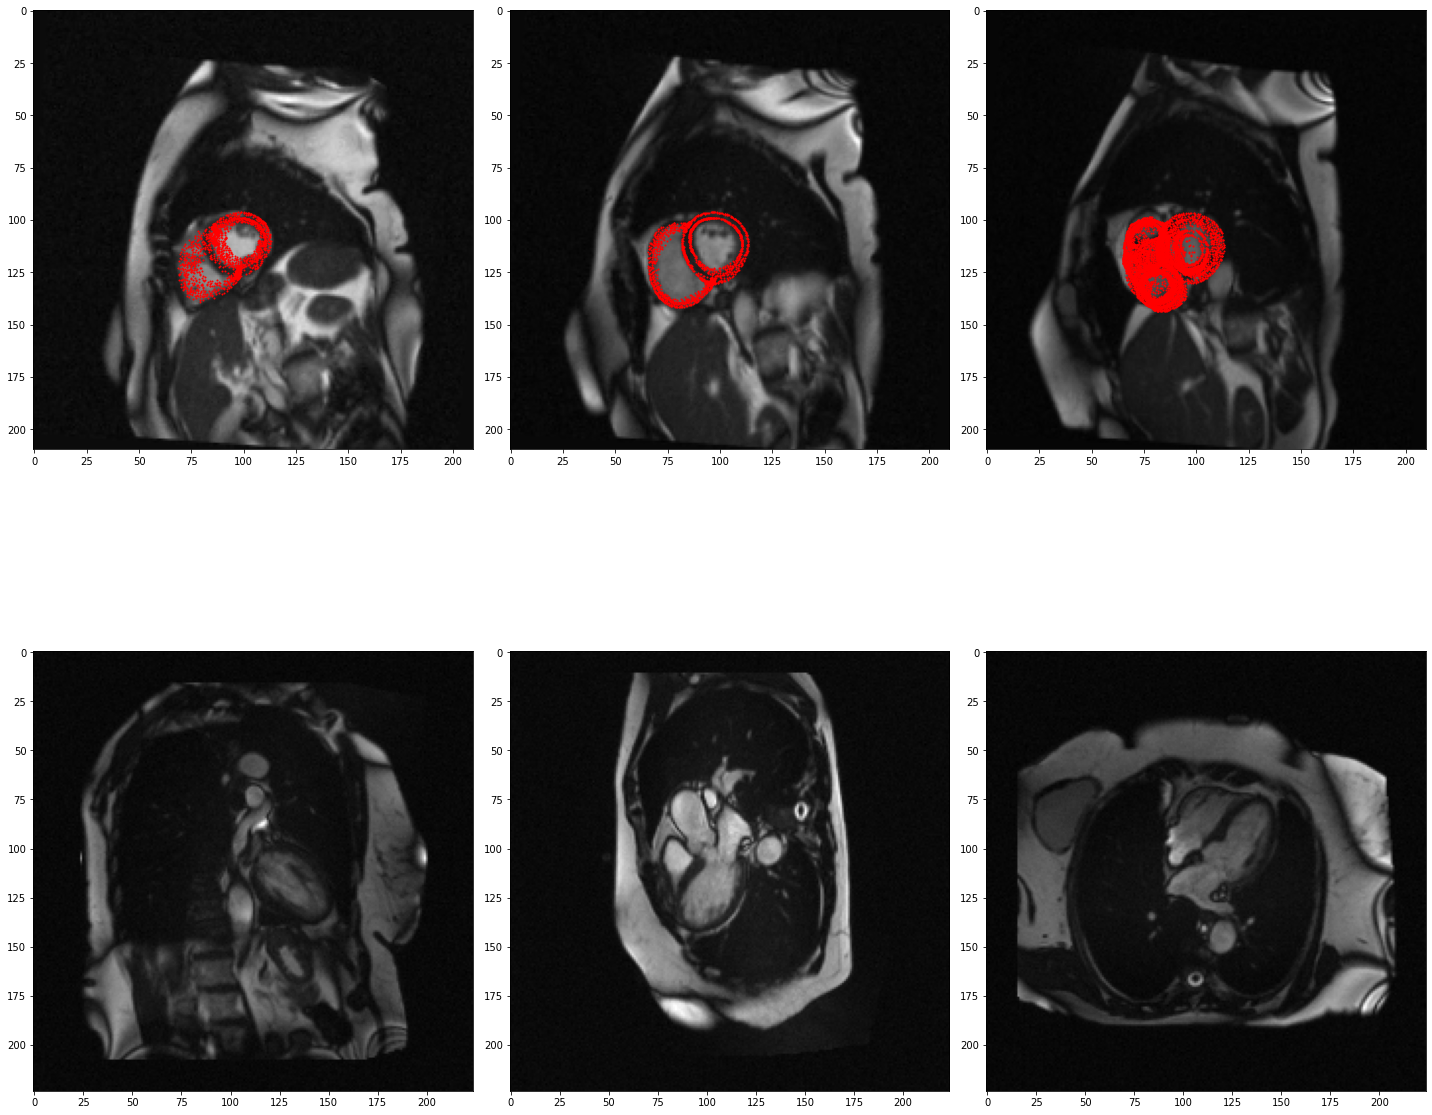

In [11]:
import matplotlib.pyplot as plt

mesh = sample["Mesh"]
m1 = mesh[:, 2] < (7 / 16) * (mesh[:, 2] > (5 / 16))
m1 = mesh[m1, :] * 210

m2 = mesh[:, 2] < (9 / 16) * (mesh[:, 2] > (7 / 16))
m2 = mesh[m2, :] * 210

m3 = mesh[:, 2] < (11 / 16) * (mesh[:, 2] > (9 / 16))
m3 = mesh[m3, :] * 210

plt.figure(figsize=(20, 20))

plt.subplot(2, 3, 1)
plt.imshow(sample["Sax_Array"][0, 7, :, :].cpu().numpy(), cmap="gray")
plt.scatter(m1[:, 0], m1[:, 1], s=1, c="red")

plt.subplot(2, 3, 2)
plt.imshow(sample["Sax_Array"][0, 9, :, :].cpu().numpy(), cmap="gray")
plt.scatter(m2[:, 0], m2[:, 1], s=1, c="red")

plt.subplot(2, 3, 3)
plt.imshow(sample["Sax_Array"][0, 11, :, :].cpu().numpy(), cmap="gray")
plt.scatter(m3[:, 0], m3[:, 1], s=1, c="red")

plt.subplot(2, 3, 4)
plt.imshow(sample["Lax2CH_Array"][0, :, :].cpu().numpy(), cmap="gray")

plt.subplot(2, 3, 5)
plt.imshow(sample["Lax3CH_Array"][0, :, :].cpu().numpy(), cmap="gray")

plt.subplot(2, 3, 6)
plt.imshow(sample["Lax4CH_Array"][0, :, :].cpu().numpy(), cmap="gray")

plt.tight_layout()
